## 201710757 김지훈
### https://github.com/201710757/NLP_SMU

In [1]:
import torch

In [3]:
import torch.nn as nn
import torchvision.datasets as dset
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [4]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2

num_classes = 10
batch_size = 100
num_epochs = 2
learning_rate = 0.01

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
mnist_train = dset.MNIST("", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

0it [00:00, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw


0it [00:00, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw
Processing...
Done!


MNIST_TRAIN LEN :  60000
MNIST_TEST LEN :  10000
Img shape torch.Size([1, 28, 28])
label :  5


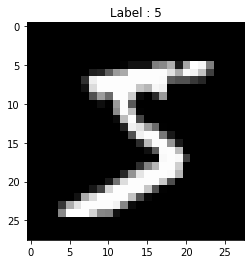

In [9]:
print("MNIST_TRAIN LEN : ", len(mnist_train))
print("MNIST_TEST LEN : ", len(mnist_test))

img, label = mnist_train.__getitem__(0)
print("Img shape", img.size())
print("label : ", label)

img = img.numpy()
plt.title("Label : %d" %label)
plt.imshow(img[0], cmap='gray')
plt.show()

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

[0]
한번에 로드되는 데이터 크기 100


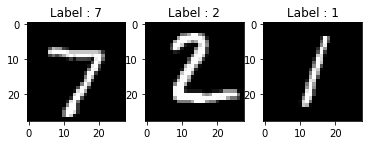

[1]
한번에 로드되는 데이터 크기 100


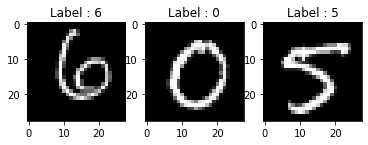

[2]
한번에 로드되는 데이터 크기 100


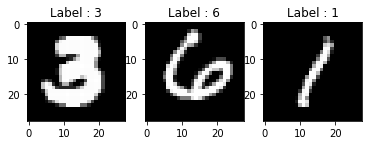

[3]
한번에 로드되는 데이터 크기 100


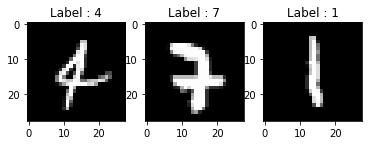

[4]
한번에 로드되는 데이터 크기 100


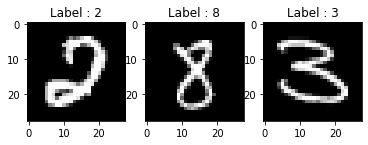

[5]
한번에 로드되는 데이터 크기 100


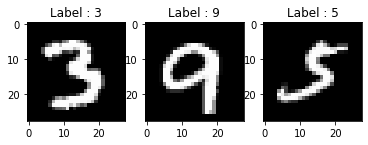

In [11]:
n = 3

for i, [imgs, labels] in enumerate(test_loader):
    if i > 5:
        break
    print("[%d]"%i)
    print("한번에 로드되는 데이터 크기", len(imgs))
    
    for j in range(n):
        img = imgs[j].numpy()
        img = img.reshape((img.shape[1], img.shape[2]))
        
        plt.subplot(1, n, j+1)
        plt.imshow(img, cmap='gray')
        plt.title("Label : %d" % labels[j])
    plt.show()

In [12]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        
        return out

In [14]:
model = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [15]:
def ComputeAccr(dloader, imodel):
    correct = 0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader):
        img = imgs
        img = img.reshape(-1, sequence_length, input_size).to(device)
        
        label = labels.to(device)
        output = imodel(img)
        _, output_index = torch.max(output, 1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    return (100 * correct / total).numpy()

In [16]:
print("ACC of test Data : %.2f" %ComputeAccr(test_loader, model))

ACC of test Data : 8.44


In [17]:
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [20]:
total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, [imgs, labels] in enumerate(train_loader):
        img = imgs
        img = img.reshape(-1, sequence_length, input_size).to(device)
        
        label = labels.to(device)
        
        output = model(img)
        loss = loss_func(output, label)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print("Epoch [{}/{}], step [{}/{}], Loss : {:.4f}, Accr: {:.2f}".format(epoch+1,num_epochs, i+1, total_step, loss.item(), ComputeAccr(test_loader, model)))
        

Epoch [1/2], step [100/600], Loss : 0.6716, Accr: 80.54
Epoch [1/2], step [200/600], Loss : 0.3036, Accr: 92.55
Epoch [1/2], step [300/600], Loss : 0.1326, Accr: 95.11
Epoch [1/2], step [400/600], Loss : 0.0937, Accr: 95.31
Epoch [1/2], step [500/600], Loss : 0.0791, Accr: 96.28
Epoch [1/2], step [600/600], Loss : 0.1036, Accr: 96.14
Epoch [2/2], step [100/600], Loss : 0.0612, Accr: 97.36
Epoch [2/2], step [200/600], Loss : 0.0665, Accr: 97.58
Epoch [2/2], step [300/600], Loss : 0.1013, Accr: 97.14
Epoch [2/2], step [400/600], Loss : 0.1183, Accr: 97.91
Epoch [2/2], step [500/600], Loss : 0.0952, Accr: 97.68
Epoch [2/2], step [600/600], Loss : 0.0273, Accr: 97.45


In [21]:
print("ACC of test Data : %.2f" %ComputeAccr(test_loader, model))

ACC of test Data : 97.45


In [22]:
netname = './nets/rnn_weight.pkl'
torch.save(model, netname)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/serialization.py:360: UserWarning: Couldn't retrieve source code for container of type RNN. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [23]:
# Load parameters
netname = './nets/rnn_weight.pkl'

model = torch.load(netname)
print("Load Parameter - ACC of test Data : %.2f" %ComputeAccr(test_loader, model))

Load Parameter - ACC of test Data : 97.45
